**MNIST Dataset을 활용한 분류 모델 실습**

In [1]:
# 파이썬 ≥3.5 필수, 이하일 경우 assert 에러
import sys
assert sys.version_info >= (3, 5)


# sklearn version 0.20 이상.
import sklearn
assert sklearn.__version__ >= "0.20"
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# 공통 모듈 임포트
import numpy as np
import os

# 실습 결과를 동일하게 하기 위해서
np.random.seed(42)

# 깔끔한 그래프 출력을 위해서
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치 설정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The scikit-learn version is 1.2.2.


In [2]:
#MNIST dataset 다운로드 받기 (약간의 시간 필요)

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

#MNIST dataset은 딕셔너리 구조를 가지고 있음.
#데이터셋을 설명하는 'DESER' 키
#샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 'data' 키

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:

mnist


{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
28 * 28

784

그림 저장: some_digit_plot


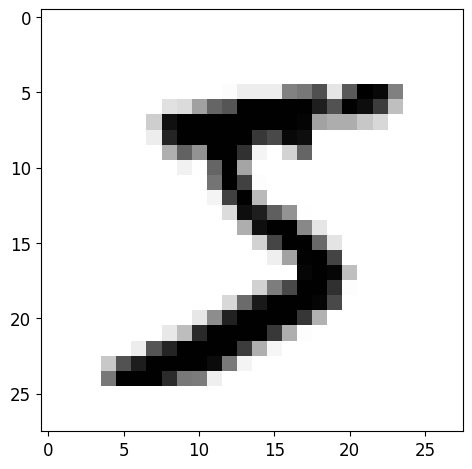

In [7]:
# 첫번째 샘플에 대한 특성 data를 28,28 픽셀로 출력하기
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("on")

save_fig("some_digit_plot")
plt.show()

In [8]:
#첫번째 샘플의 레이블 확인하기
y[0]

'5'

In [9]:
## 레이블은 숫자가 아닌 문자열
## 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

y = y.astype(np.uint8)

In [10]:
# 샘플의 특성 data를 28,28 픽셀로 출력하는 함수 만들기.

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
# 숫자 그림을 위한 추가 함수

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


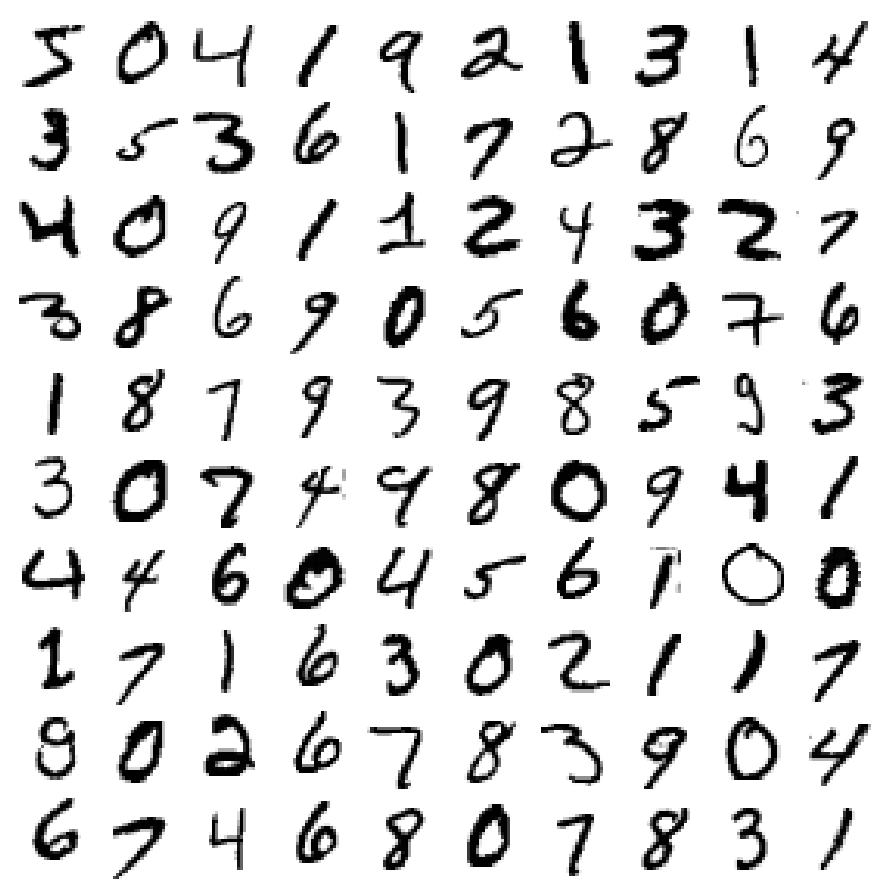

In [15]:
## 10X10으로 그리려면 images_per_row를 10으로 변경.

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [16]:
#첫번째, 두번째, 세번째 샘플의 레이블 확인하기.
y[0], y[1], y[2]

(5, 0, 4)

In [17]:
#training set, test set 지정하기. 60,000개, 10,000개

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print (y_train[0])
print (y_train[11])

5
5


# Binary Classification 실습

In [18]:
# 5는 True이고, 다른 숫자는 모두 False

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#print (X_train)
#print (X_test.shape)
#print (y_train)
#print (y_test)
print (y_train_5[0],y_train_5[11], y_train_5[12])
print (y_test_5)

True True False
[False False False ... False  True False]


In [19]:
# SGD Classifier 적용 분류 모델 만들어 보기.
# 5이면 true로 , 5가 아니면 false로 분류하는 Binary Classification.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=17)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=17)

In [20]:
sgd_clf.predict([some_digit])

## some_digit = X[0]

array([ True])

In [ ]:
## cross_val_score : 단순교차검증
## 3-폴드 교차 검증 수행

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96675, 0.9618 , 0.94425])

In [ ]:
## StratifiedKFold : 계층별 k-겹 교차 검증 (클래스별 비율이 유지되도록 폴드를 만듦)
## k-fold 에서 데이터(레이블 or 클래스)가 한 곳으로 몰리는 것을 방지

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

## 위에서 만들 모델, "sgd_clf.fit(X_train, y_train_5)"을 "clone_clf"라는 이름으로 담기.

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9681
0.9651
0.9653


In [ ]:
## 모든 이미지를 "5아님" 클래스로 분류하는 dummy classifier 생성해보기.

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

## 10개중에 1개만 "5"이므로 모두 5가 아니라고 분류하는 모델을 만들면
## 정확도가 90% 이상 나오게 됨.
## Accuracy가 높다고 해서 무조건 좋은 모델이라고 오판해서는 안됨!!

array([0.91125, 0.90855, 0.90915])

In [ ]:
# 모두 False로 예측 하는지 체크!

from sklearn.model_selection import cross_val_predict
y_never_5_pred = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)
print (y_never_5_pred)


[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


In [ ]:
## 다시 sgd_clf 모델(In 68에서 생성)을 활용하여 예측값에 대한 array (y_train_pred)생성.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

print (y_train_pred)

[ True False False ...  True False False]


In [ ]:
## 오차 행렬 확인하기

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53936,   643],
       [ 1901,  3520]], dtype=int64)

In [ ]:
## 예측값의 자리에 정답을 놓고 오차 행렬을 확인해보면...
## 완벽한 분류기의 결과를 보임.

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [ ]:
## 정밀도 확인 (sklearn 함수 제공)

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8455440787893346

In [ ]:
## 정밀도를 CM으로부터 직접 계산

cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8455440787893346

In [ ]:
## 재현율 확인 (sklearn 함수 제공)

recall_score(y_train_5, y_train_pred)

0.6493266924921601

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6493266924921601

In [ ]:
## F1 score 확인 (sklearn 함수 제공)

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7345575959933222

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7345575959933222

## 정밀도/재현율 트레이드오프

In [ ]:
## decision_function()메서드를 호출하여 각 샘플의 점수를 확인해보자.
## 이 점수가 임계값(threshold)보다 크면 양성(True)으로 분류함.

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1067.64798936])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

## 이미지가 실제로 숫자 5이고 임계값이 0일때는 분류기가 이를 감지했지만, 임계값을 높이면 이를 놓치게 됨.
## 따라서 True Positive는 줄어들고 False Negative은 늘어나므로 재현율은 감소하게 됨.
## Threshold가 양의 방향으로 커지면 재현율은 감소하게 됨.

array([False])

In [ ]:
## decision_function()메서드를 사용하여 y_scores array 생성.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([  2402.52975074, -13366.16421546, -25713.60673974, ...,
         4283.08132713, -13004.21253155, -21784.1670382 ])

In [ ]:
## precision_recall_curve 함수를 사용하면 threshold 값에 따른 precision, recall 값들을 가져옴.

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 각 값들을 직접 확인해보자.
#print (precision_recall_curve(y_train_5, y_scores))
#print (precisions)
#print (recalls)
#print (thresholds)

그림 저장: precision_recall_vs_threshold_plot


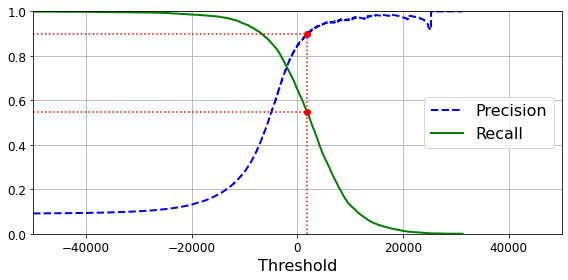

In [ ]:
##threshold에 따른 정밀도/재현율 그리기 함수 만들기.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


## 그리기 설정.
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
##(y_train_pred == (y_scores > 0)).all()

True

[0.09044799 0.09043281 0.09043432 ... 1.         1.         1.        ]
[1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
그림 저장: precision_vs_recall_plot


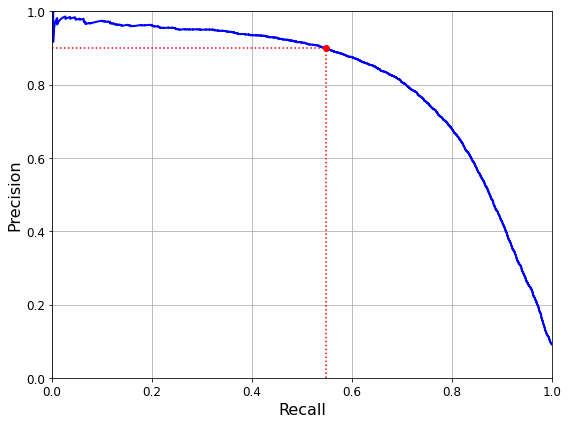

In [ ]:
## 정밀도/재현율 trade off 관계 그림 그려보기.

print (precisions)
print (recalls)


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
## 정밀도 90% 달성을 목표로 설정.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


In [ ]:
threshold_90_precision

1854.5025990559493

In [ ]:
## y_scores가 1854보다 크거나 같으면 True, 작으면 false 라고 하고,
## 이 결과를 y_train_pred_90에 담기.

y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False, False, ...,  True, False, False])

In [ ]:
## 실제 정확도를 확인해보기

precision_score(y_train_5, y_train_pred_90)

0.9001214329083181

In [ ]:
## 재현율도 확인해보기

recall_score(y_train_5, y_train_pred_90)

0.5469470577384247

In [ ]:
## ROC곡선 그려보기
## roc_curve 함수를 통해서 threshold의 변화에 따른 fpr, tpr 값의 변화를 가져오기.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

0.0060279594715916375
0.5469470577384247
그림 저장: roc_curve_plot


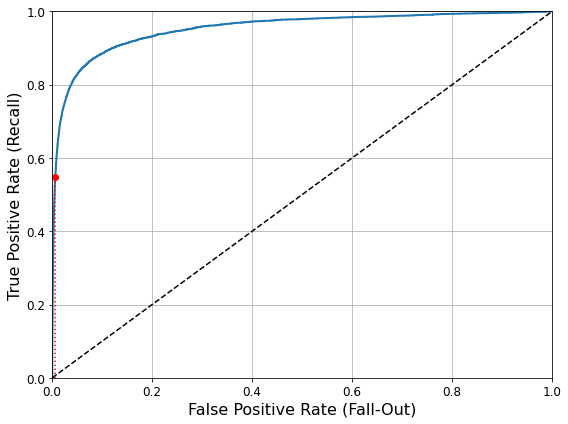

In [ ]:
## ROC곡선 그리기 함수 만들기

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
print (fpr_90)
print (recall_90_precision)
#plt.plot([0.2, 0.7], [0.3, 0.5], "r:")   # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [ ]:
## roc_auc_score 함수를 이용하여 분류기 성능 체크

from sklearn.metrics import roc_auc_score

print (y_train_5)
print (y_scores)

roc_auc_score(y_train_5, y_scores)



[ True False False ...  True False False]
[  2402.52975074 -13366.16421546 -25713.60673974 ...   4283.08132713
 -13004.21253155 -21784.1670382 ]


0.953268587325405

In [ ]:
## Random Forest 분류기로 훈련 시키기.

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
## predict_proba 메서드를 활용하여 양성 클래스일 확률을 점수로 사용.


y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률

print (y_train_5)
print (y_scores_forest)

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

[ True False False ...  True False False]
[0.89 0.01 0.04 ... 0.98 0.08 0.06]


0.9584947426674045
그림 저장: roc_curve_comparison_plot


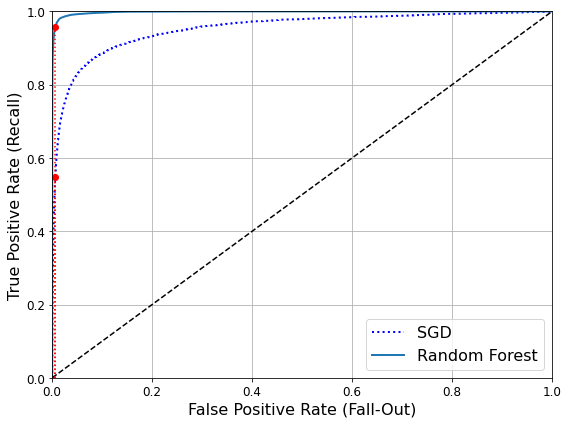

In [ ]:
## SGD와 random forest 알고리즘에 따른 ROC 커브 비교.

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

print (recall_for_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591